In [1]:
import squidpy as sq
import scanpy as sc
import spatialdata as sd
import spatialdata_plot
from pathlib import Path
import seaborn as sns
import pandas as pd
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
runLabel = 'XeniumLungCancer' 
xenium_path = "/home/hanyue/code/biomecha/data/large_data/"+runLabel+".zarr"
save_path = '/home/hanyue/code/biomecha/data/large_data/Results/XeniumLungCancer'
sdata = sd.read_zarr(xenium_path)
sdata

/home/hanyue/anaconda3/envs/py310bio/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object with:
├── Images
│     ├── 'he_image': MultiscaleSpatialImage[cyx] (3, 45087, 11580), (3, 22543, 5790), (3, 11271, 2895), (3, 5635, 1447), (3, 2817, 723)
│     └── 'morphology_focus': MultiscaleSpatialImage[cyx] (5, 17098, 51187), (5, 8549, 25593), (5, 4274, 12796), (5, 2137, 6398), (5, 1068, 3199)
├── Labels
│     ├── 'cell_labels': MultiscaleSpatialImage[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': MultiscaleSpatialImage[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (12165021, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (162254, 377)
with coordinate systems:
▸ 'global', with elements

In [3]:
adata = sdata["table"].copy()
adata

AnnData object with n_obs × n_vars = 162254 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

# Preprocessing

In [4]:
import sys
sys.path.append('/home/hanyue/code/biomecha/SpatialZoomer')
from Preprocessing  import *

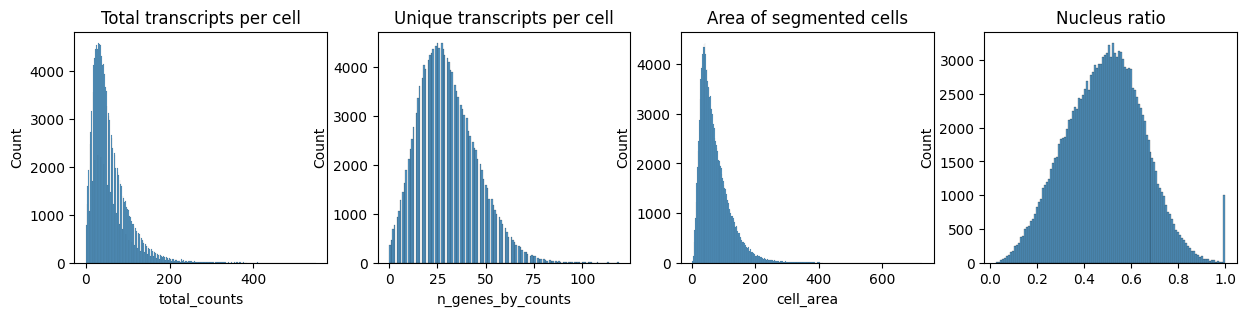

In [5]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)
plot_qc_hist(adata)

In [6]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)
adata = adata[~adata.obs['nucleus_area'].isna(), :]
adata = Preprocess(adata)
adata

/home/hanyue/code/biomecha/SpatialZoomer/Preprocessing.py:39: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


AnnData object with n_obs × n_vars = 149195 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatialdata_attrs', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

# GWT

In [7]:
from Graph_wavelet_transform import *

In [8]:
n_neighbors = 20
adata = performDR(adata, type = 'NMF', n_components=50)
adata = getKNN(adata, use_rep = 'spatial', name = 'spatial_knn', n_neighbors = n_neighbors)
adata = getKNN(adata, use_rep = 'X_nmf', name = 'expr_knn', n_neighbors = n_neighbors)

scales = [0.01] + np.arange(0.1, 2.1, 0.1).tolist() + np.arange(2.5, 15.5, 0.5).tolist() + np.arange(16, 21, 1).tolist() +  np.arange(25, 55, 5).tolist()
scales = [round(x, 2) for x in scales]
transformed_signals, scales = performGWT(adata, use_knn = 'spatial_knn', use_rep = 'X_nmf', scales = scales, runLabel = runLabel, save_path = save_path)

Time taken to perform NMF: 58.1187 seconds
Maximum similarities:  68.1586526262618
Minimum similarities:  0.17508957696521626
Median similarities:  5.61037530537644
Time taken to construct spatial_knn: 0.8125 seconds
Maximum similarities:  12498.371103009902
Minimum similarities:  495.41297084686636
Median similarities:  1000.7886534928216
Time taken to construct expr_knn: 13.6547 seconds


2024-10-02 16:01:39,893:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


Time taken to perform GWT: 114.0383 seconds


In [9]:
print(transformed_signals.shape)

(149195, 50, 58)


# Identify typical frequency

In [10]:
from Identify_frequency import *

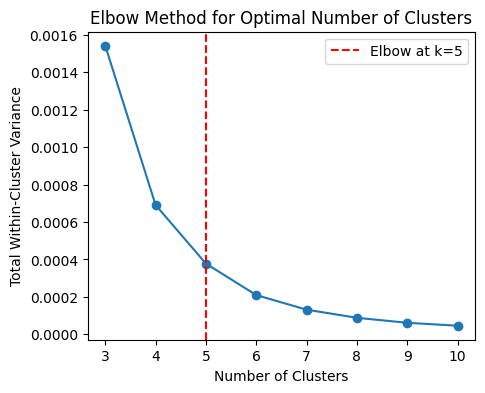

The optimal number of clusters is: 5


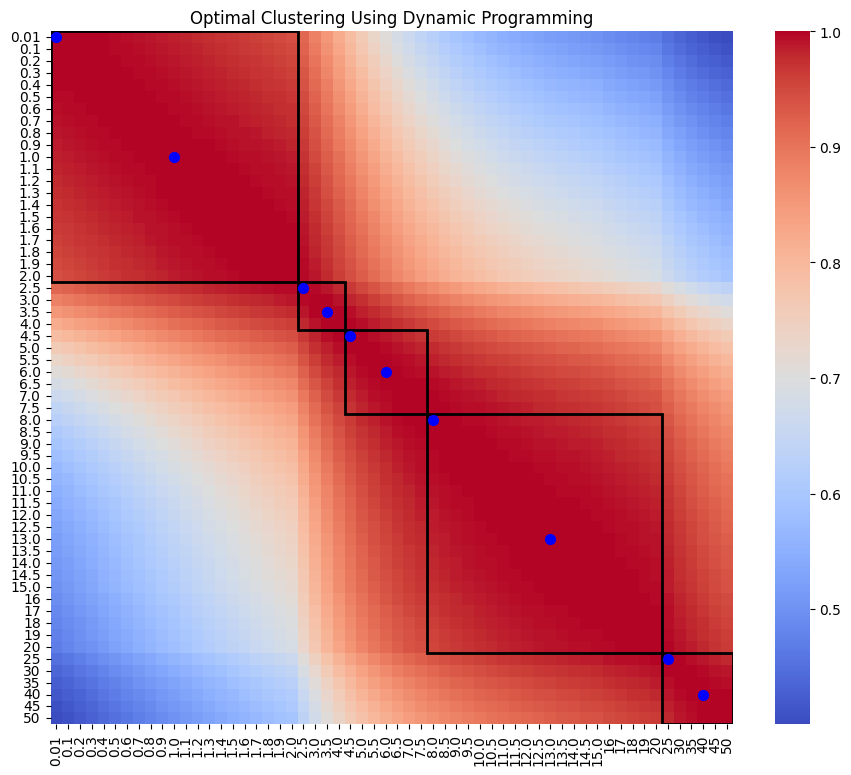

Optimal clusters (start, end): [(0, 20), (21, 24), (25, 31), (32, 51), (52, 57)]
Cluster centers: [1.0, 3.5, 6.0, 13.0, 40]
Typical scales: [0.01, 1.0, 2.5, 3.5, 4.5, 6.0, 8.0, 13.0, 25, 40]


,Index,Scale
0,0,0.01
1,10,1.00
2,21,2.50
3,23,3.50
4,25,4.50
5,28,6.00
6,32,8.00
7,42,13.00
8,52,25.00
9,55,40.00


In [11]:
mean_correlation_matrix, optimal_clusters, typical_scales_df = IdentifyFrequency(transformed_signals, scales, max_clusters = 10, min_clusters = 3, 
                                                                             save_path = save_path+'/'+ runLabel )
typical_scales_df 

# Clustering

In [12]:
from Clustering_old import *
import importlib
importlib.reload(sys.modules['Clustering_old'])

<module 'Clustering_old' from '/home/hanyue/code/biomecha/SpatialZoomer/Clustering_old.py'>

In [13]:
resolutions = [0.4, 0.6, 0.8, 1, 1.2]
adata = Clustering_raw_signal(adata, use_rep = 'X_nmf',  n_clusters_kmeans = 10000, resolutions = resolutions, title = 'Raw', save_path = save_path, runLabel = runLabel)

Time taken to perform UMAP and clustering for raw signal: 399.7397 seconds


In [14]:
adata = Clustering_transformed_signal(adata, transformed_signals, typical_scales_df, n_clusters_kmeans = 10000, resolutions = resolutions, save_path = save_path, runLabel = runLabel)

Time taken to perform clustering for signal at scale 0.01: 423.8669 seconds
Time taken to perform clustering for signal at scale 1.0: 515.8474 seconds
Time taken to perform clustering for signal at scale 2.5: 326.8848 seconds
Time taken to perform clustering for signal at scale 3.5: 240.3809 seconds
Time taken to perform clustering for signal at scale 4.5: 231.9565 seconds
Time taken to perform clustering for signal at scale 6.0: 219.0999 seconds
Time taken to perform clustering for signal at scale 8.0: 219.1308 seconds
Time taken to perform clustering for signal at scale 13.0: 227.2931 seconds
Time taken to perform clustering for signal at scale 25.0: 202.9786 seconds
Time taken to perform clustering for signal at scale 40.0: 221.8895 seconds
Total time: 2829.7449 seconds


In [15]:
from Simpson_Index import *
importlib.reload(sys.modules['Simpson_Index'])

<module 'Simpson_Index' from '/home/hanyue/code/biomecha/SpatialZoomer/Simpson_Index.py'>

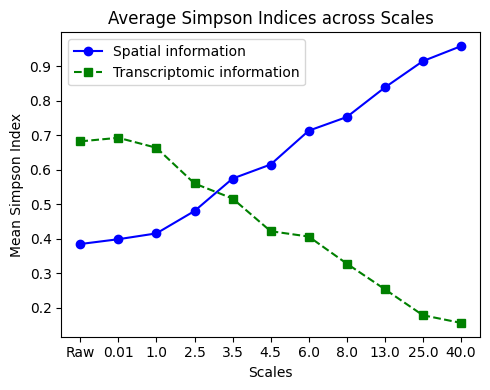

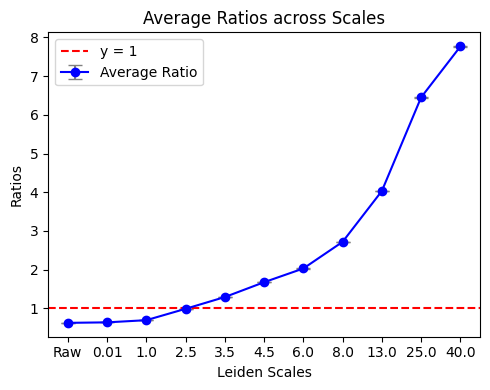

In [16]:
from scipy.sparse import load_npz
spatial_knn = adata.obsp['spatial_knn'].copy()
spatial_knn = spatial_knn.tocsr()  

expr_knn = adata.obsp['expr_knn'].copy()
expr_knn = expr_knn.tocsr()  

spatial_knn_binarized = binarize_knn_matrix(spatial_knn)
expr_knn_binarized = binarize_knn_matrix(expr_knn)

typical_scales = typical_scales_df['Scale'].values
leiden_scales = ['leiden_Raw_res1'] + ['leiden_scale' + str(scale) + '_res1' for scale in typical_scales]
umap_scales = ['X_umap_'+str(scale) for scale in typical_scales]
scales_plot = ['Raw'] + [str(scale) for scale in typical_scales]
simpson_spatial_dict, simpson_expr_dict, ratios_dict = plot_simpson_indices(adata, spatial_knn_binarized, expr_knn_binarized, scales_plot, leiden_scales, save_path = save_path+'/')


In [17]:
from Identify_spatial_dependent_clusters import *
importlib.reload(sys.modules['Identify_spatial_dependent_clusters'])


<module 'Identify_spatial_dependent_clusters' from '/home/hanyue/code/biomecha/SpatialZoomer/Identify_spatial_dependent_clusters.py'>

X_umap_scale0.01
Number of Peaks: 2
X_umap_scale1.0
Number of Peaks: 1


X_umap_scale2.5
Number of Peaks: 2
X_umap_scale3.5
Number of Peaks: 2
X_umap_scale4.5
Number of Peaks: 2
X_umap_scale6.0
Number of Peaks: 2
X_umap_scale8.0
Number of Peaks: 4
X_umap_scale13.0
Number of Peaks: 3
X_umap_scale25.0
Number of Peaks: 1
X_umap_scale40.0
Number of Peaks: 2


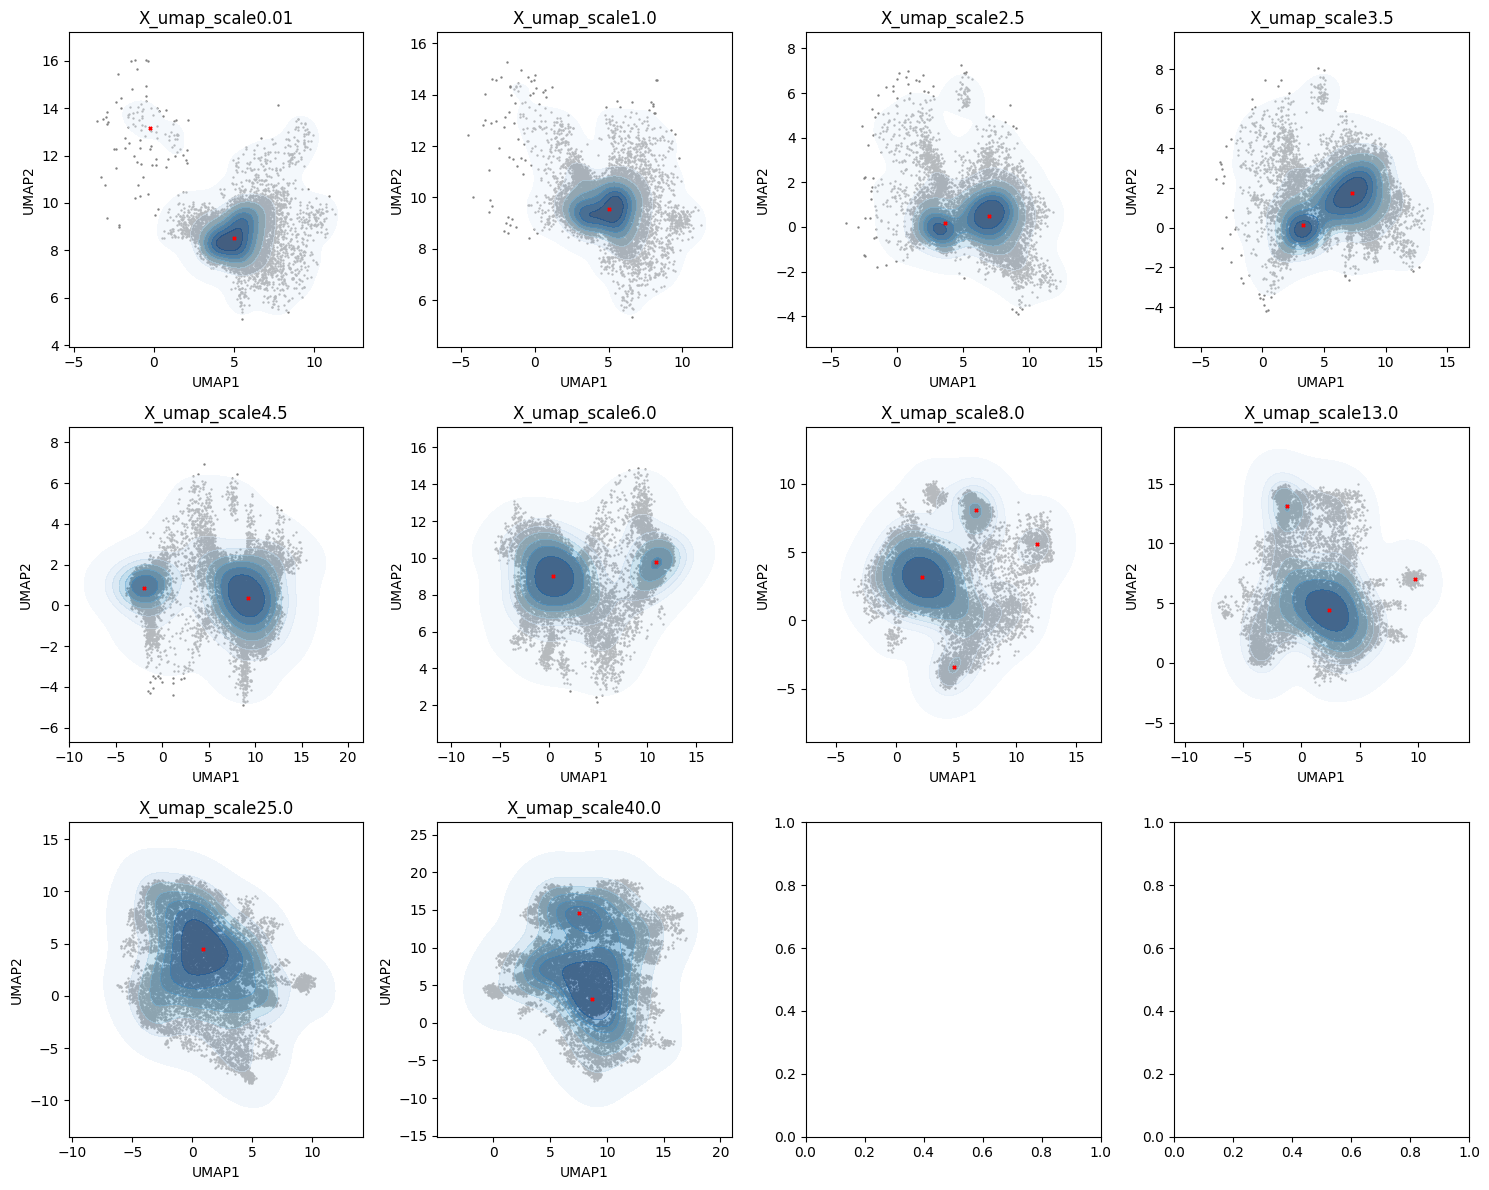

In [18]:
from Identify_spatial_dependent_clusters import *
importlib.reload(sys.modules['Identify_spatial_dependent_clusters'])

fig, axs = plt.subplots(3, 4, figsize=(15, 12))
axs = axs.flatten()
i = 0

umap_keys = ['X_umap_scale' + str(scale) for scale in typical_scales]
for umap_scale in umap_keys:
    print(umap_scale)
    X = adata[adata.obs['leiden_Raw_res1'] == 'C5'].obsm[umap_scale]
    X = X + np.random.normal(0, 0.2, size=X.shape)  
    n_components, mean_intra_cluster_distance, mean_inter_cluster_distance, d_mahalanobis = gmm_density_fit(axs[i], X, umap_scale)
    i += 1
plt.tight_layout()
plt.show()

X_umap_scale0.01
Number of Peaks: 2
X_umap_scale1.0
Number of Peaks: 1
X_umap_scale2.5
Number of Peaks: 2
X_umap_scale3.5
Number of Peaks: 2
X_umap_scale4.5
Number of Peaks: 2
X_umap_scale6.0
Number of Peaks: 2
X_umap_scale8.0
Number of Peaks: 4
X_umap_scale13.0
Number of Peaks: 2
X_umap_scale25.0
Number of Peaks: 1
X_umap_scale40.0
Number of Peaks: 2


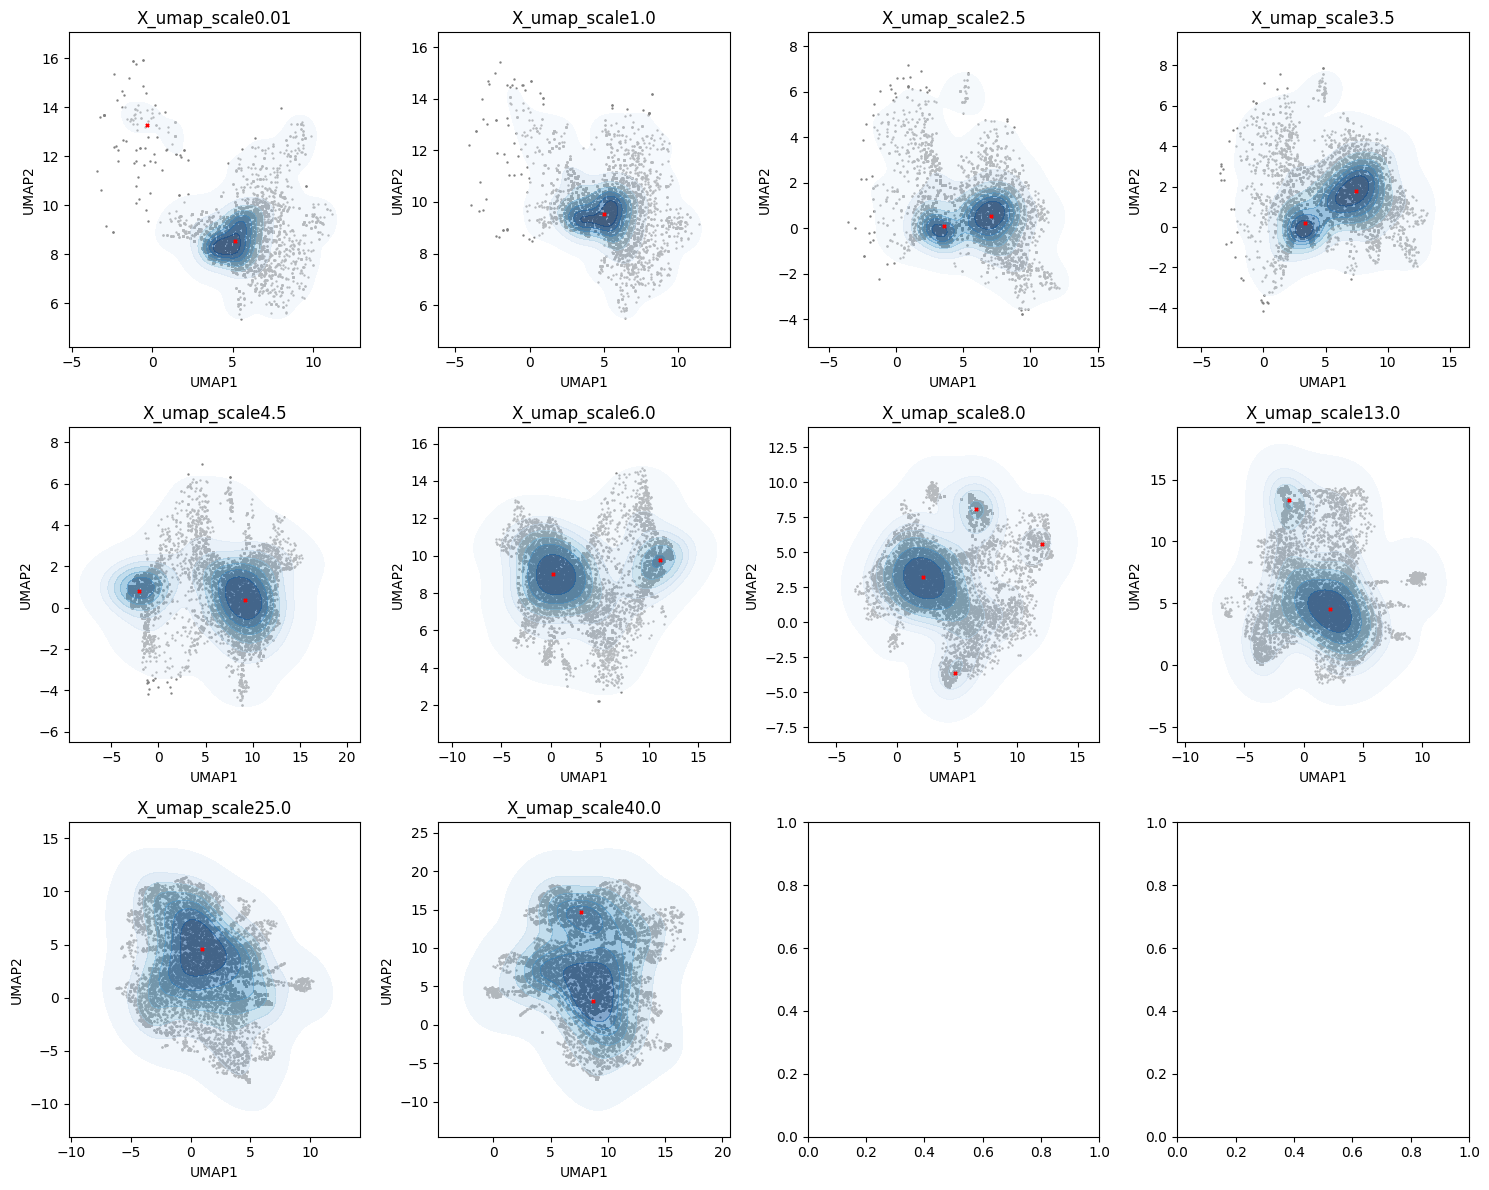

In [23]:
from Identify_spatial_dependent_clusters import *
importlib.reload(sys.modules['Identify_spatial_dependent_clusters'])

fig, axs = plt.subplots(3, 4, figsize=(15, 12))
axs = axs.flatten()
i = 0

umap_keys = ['X_umap_scale' + str(scale) for scale in typical_scales]
for umap_scale in umap_keys:
    print(umap_scale)
    X = adata[adata.obs['leiden_Raw_res1'] == 'C5'].obsm[umap_scale]
    #X = X + np.random.normal(0, 0.2, size=X.shape)  
    n_components, mean_intra_cluster_distance, mean_inter_cluster_distance, d_mahalanobis = gmm_density_fit(axs[i], X, umap_scale)
    i += 1
plt.tight_layout()
plt.show()

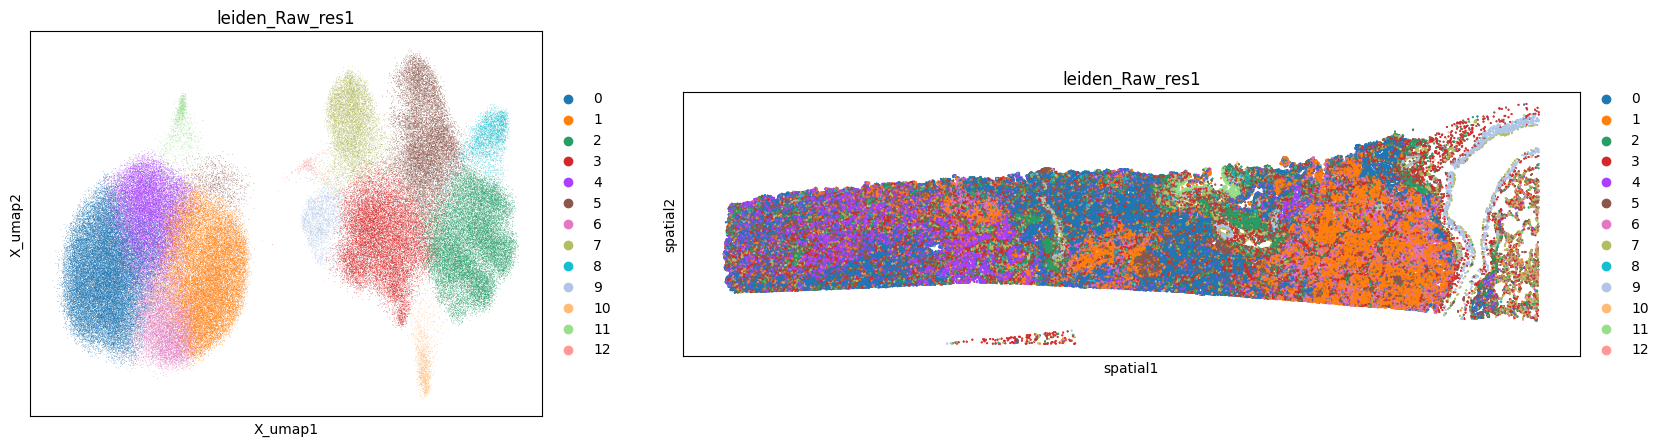

In [34]:
gs = gridspec.GridSpec(1, 2, width_ratios=[8, 14])  # 12:16 的宽度比例
fig = plt.figure(figsize=(20, 5))  # 总宽度是 12+16=28，高度是 8

# 左边绘制 UMAP 图，大小为 12x8
ax1 = plt.subplot(gs[0, 0])
sc.pl.embedding(
    adata,
    basis='X_umap',
    color='leiden_Raw_res1',  # 使用 leinden_scale 对应的列
    ax=ax1,
    show=False  # 不立即显示图像
)

# 右上角：空间散点图，基于 leiden_scale
ax2 = plt.subplot(gs[0, 1])
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color='leiden_Raw_res1',  # 使用 leinden_scale 对应的列
    wspace=0.4,
    ax=ax2
)


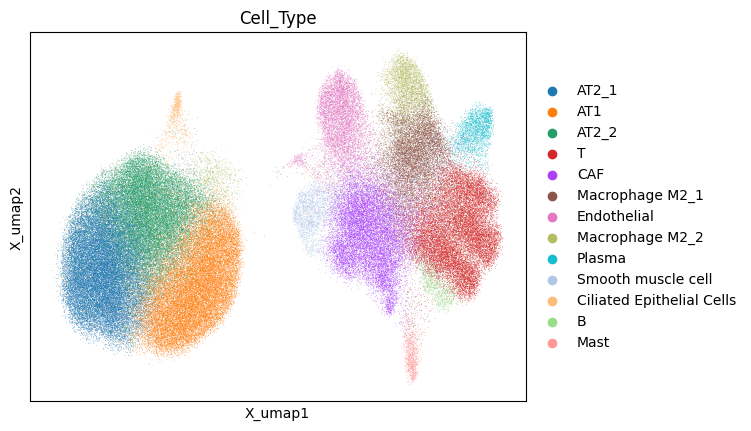

In [40]:
adata_raw = sc.read('/home/hanyue/code/biomecha/data/large_data/XeniumLungCancer/save_results/XeniumLungCancer_GWT_KL.h5ad')
adata.obs['Cell_Type'] = adata_raw.obs['Cell_Type']
sc.pl.embedding(
    adata,
    basis='X_umap',
    color='Cell_Type',  # 使用 leinden_scale 对应的列
)


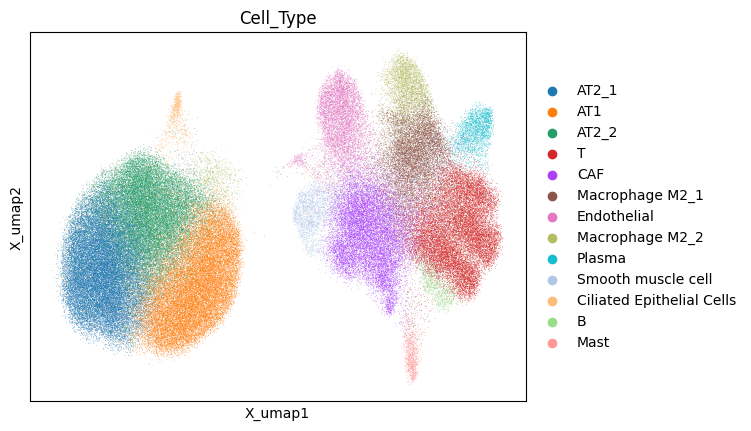

In [ ]:
adata_raw = sc.read('/home/hanyue/code/biomecha/data/large_data/XeniumLungCancer/save_results/XeniumLungCancer_GWT_KL.h5ad')
adata.obs['Cell_Type'] = adata_raw.obs['Cell_Type']
sc.pl.embedding(
    adata,
    basis='X_umap',
    color='Cell_Type',  # 使用 leinden_scale 对应的列
)


In [44]:
resolutions = [0.4, 0.6, 0.8, 1, 1.2]
adata = Clustering_transformed_signal(adata, transformed_signals, typical_scales_df, n_clusters_kmeans = 10000, resolutions = resolutions, save_path = save_path, runLabel = runLabel)

Time taken to perform clustering for signal at scale 0.01: 527.1568 seconds
Time taken to perform clustering for signal at scale 1.0: 336.4466 seconds
Time taken to perform clustering for signal at scale 2.5: 239.3534 seconds
Time taken to perform clustering for signal at scale 3.5: 230.2906 seconds
Time taken to perform clustering for signal at scale 4.5: 217.8837 seconds
Time taken to perform clustering for signal at scale 6.0: 324.1170 seconds
Time taken to perform clustering for signal at scale 8.0: 232.3240 seconds
Time taken to perform clustering for signal at scale 13.0: 450.7154 seconds
Time taken to perform clustering for signal at scale 25.0: 449.3624 seconds
Time taken to perform clustering for signal at scale 40.0: 485.6668 seconds
Total time: 3493.7371 seconds


# Identify typical scales

In [ ]:

from Simpson_Index import *
importlib.reload(sys.modules['Simpson_Index'])

from scipy.sparse import load_npz
spatial_knn = adata.obsp['spatial_knn'].copy()
spatial_knn = spatial_knn.tocsr()  

expr_knn = adata.obsp['expr_knn'].copy()
expr_knn = expr_knn.tocsr()  

spatial_knn_binarized = binarize_knn_matrix(spatial_knn)
expr_knn_binarized = binarize_knn_matrix(expr_knn)

typical_scales = typical_scales_df['Scale'].values
leiden_scales = ['leiden_Raw_res1'] + ['leiden_scale' + str(scale) + '_res1' for scale in typical_scales]
umap_scales = ['X_umap_'+str(scale) for scale in typical_scales]
scales_plot = ['Raw'] + [str(scale) for scale in typical_scales]
simpson_spatial_dict, simpson_expr_dict, ratios_dict = plot_simpson_indices(adata, spatial_knn_binarized, expr_knn_binarized, scales_plot, leiden_scales, save_path = save_path+'/')

